## Big Data Demo

Let's see how snowflake does at scale
This demo walks through data prep and modeling for a large dataset.
This notebook comes from [TPCDS Customer Lifetime demo](https://github.com/Snowflake-Labs/snowpark-python-demos/tree/main/tpcds-customer-lifetime-value)

If you are running this in your local environment, you will need to make sure you use versions of sklearn and xgboost that are supported in snowflake. Otherwise, you will get an error when you try to push the model to snowflake.

In [1]:
# Base dir for this code
import os
base_dir = os.getcwd()
print(base_dir)

/Users/rajishah/Code/snowflake-notebooks/BigData_Demo


In [2]:
import json
import pandas as pd

from snowflake.snowpark import functions as F
from snowflake.snowpark.version import VERSION
from snowflake.snowpark.session import Session

from snowflake.ml._internal import env as snowml_env
from snowflake.ml.modeling.xgboost import XGBRegressor
from snowflake.ml.modeling.preprocessing import KBinsDiscretizer, OneHotEncoder
from snowflake.ml.modeling.impute import SimpleImputer
#from xgboost import XGBRegressor

In [3]:
import warnings
warnings.filterwarnings("ignore")

# 1.0 Snowflake Setup

In [4]:
with open('../../creds.json') as f:
    data = json.load(f)
    USERNAME = data['user']
    PASSWORD = data['password']
    SF_ACCOUNT = data['account']
    SF_WH = data['warehouse']

CONNECTION_PARAMETERS = {
   "account": SF_ACCOUNT,
   "user": USERNAME,
   "password": PASSWORD,
}

session = Session.builder.configs(CONNECTION_PARAMETERS).create()

In [5]:
snowflake_environment = session.sql('select current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))
print('Snowflake Python ML version : {}'.format(snowml_env.VERSION))

User                        : RSHAH
Role                        : "RAJIV"
Database                    : "RAJIV"
Schema                      : "PUBLIC"
Warehouse                   : "RAJIV"
Snowflake version           : 8.8.4
Snowpark for Python version : 1.11.1
Snowflake Python ML version : 1.2.2


#### Ensure that TPC-DS dataset is available in your environment. I found it within the SNOWFLAKE_SAMPLE_DATA shared database.

In [6]:
session.sql('CREATE DATABASE IF NOT EXISTS tpcds_xgboost').collect()
session.sql('CREATE SCHEMA IF NOT EXISTS tpcds_xgboost.demo').collect()
session.sql("create or replace warehouse FE_AND_INFERENCE_WH with warehouse_size='3X-LARGE'").collect()
session.sql("create or replace warehouse snowpark_opt_wh with warehouse_size = 'MEDIUM' warehouse_type = 'SNOWPARK-OPTIMIZED'").collect()
session.sql("alter warehouse snowpark_opt_wh set max_concurrency_level = 1").collect()
session.sql("CREATE OR REPLACE STAGE TPCDS_XGBOOST.DEMO.ML_MODELS").collect()
session.use_warehouse('FE_AND_INFERENCE_WH')
session.use_database('tpcds_xgboost')
session.use_schema('demo')

Select either 100 or 10 for the TPC-DS Dataset size to use below. See (https://docs.snowflake.com/en/user-guide/sample-data-tpcds.html)[here] for more information If you choose 100, I recommend >= 3XL warehouse. 

In [7]:
TPCDS_SIZE_PARAM = 10
SNOWFLAKE_SAMPLE_DB = 'SFSALESSHARED_SFC_SAMPLES_PROD3_SAMPLE_DATA' # Name of Snowflake Sample Database might be different...

if TPCDS_SIZE_PARAM == 100: 
    TPCDS_SCHEMA = 'TPCDS_SF100TCL'
elif TPCDS_SIZE_PARAM == 10:
    TPCDS_SCHEMA = 'TPCDS_SF10TCL'
else:
    raise ValueError("Invalid TPCDS_SIZE_PARAM selection")
    
store_sales = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.store_sales')
catalog_sales = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.catalog_sales') 
web_sales = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.web_sales') 
date = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.date_dim')
dim_stores = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.store')
customer = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.customer')
address = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.customer_address')
demo = session.table(f'{SNOWFLAKE_SAMPLE_DB}.{TPCDS_SCHEMA}.customer_demographics')

# 2.0 Data Engineering
We will aggregate sales by customer across all channels(web, store, catalogue) and join that to customer demographic data. 

In [8]:
store_sales_agged = store_sales.group_by('ss_customer_sk').agg(F.sum('ss_sales_price').as_('total_sales'))
web_sales_agged = web_sales.group_by('ws_bill_customer_sk').agg(F.sum('ws_sales_price').as_('total_sales'))
catalog_sales_agged = catalog_sales.group_by('cs_bill_customer_sk').agg(F.sum('cs_sales_price').as_('total_sales'))
store_sales_agged = store_sales_agged.rename('ss_customer_sk', 'customer_sk')
web_sales_agged = web_sales_agged.rename('ws_bill_customer_sk', 'customer_sk')
catalog_sales_agged = catalog_sales_agged.rename('cs_bill_customer_sk', 'customer_sk')

In [9]:
total_sales = store_sales_agged.union_all(web_sales_agged)
total_sales = total_sales.union_all(catalog_sales_agged)

In [10]:
total_sales = total_sales.group_by('customer_sk').agg(F.sum('total_sales').as_('total_sales'))

In [11]:
customer = customer.select('c_customer_sk','c_current_hdemo_sk', 'c_current_addr_sk', 'c_customer_id', 'c_birth_year')

In [12]:
customer = customer.join(address.select('ca_address_sk', 'ca_zip'), customer['c_current_addr_sk'] == address['ca_address_sk'] )
customer = customer.join(demo.select('cd_demo_sk', 'cd_gender', 'cd_marital_status', 'cd_credit_rating', 'cd_education_status', 'cd_dep_count'),
                                customer['c_current_hdemo_sk'] == demo['cd_demo_sk'] )
customer = customer.rename('c_customer_sk', 'customer_sk')

In [13]:
customer.limit(5).to_pandas()

,CUSTOMER_SK,C_CURRENT_HDEMO_SK,C_CURRENT_ADDR_SK,C_CUSTOMER_ID,C_BIRTH_YEAR,CA_ADDRESS_SK,CA_ZIP,CD_DEMO_SK,CD_GENDER,CD_MARITAL_STATUS,CD_CREDIT_RATING,CD_EDUCATION_STATUS,CD_DEP_COUNT
0,13823036,384,5281091,AAAAAAAAMDMOCNAA,1954,5281091,89303,384,F,S,Good,2 yr Degree,0
1,13823037,5298,29603881,AAAAAAAANDMOCNAA,1962,29603881,71749,5298,F,W,Unknown,4 yr Degree,0
2,13823038,3958,15978447,AAAAAAAAODMOCNAA,1987,15978447,26192,3958,F,W,High Risk,2 yr Degree,0
3,13823039,3605,4928437,AAAAAAAAPDMOCNAA,1965,4928437,18054,3605,M,D,High Risk,2 yr Degree,0
4,13823040,7051,4356655,AAAAAAAAAEMOCNAA,1946,4356655,61904,7051,M,M,Low Risk,Advanced Degree,1


In [14]:
final_df = total_sales.join(customer, on='customer_sk')

In [15]:
# Size of the final DF is around 95 Million.
# with 10 - raj gets 62,726,989
final_df.count()

62726989

In [ ]:
session.use_database('tpcds_xgboost')
session.use_schema('demo')
final_df.write.mode('overwrite').save_as_table('feature_store')

# 3.0 Feature Engineering

In [8]:
session.sql("create or replace warehouse snowpark_opt_wh with warehouse_size = 'MEDIUM' warehouse_type = 'SNOWPARK-OPTIMIZED'").collect()
session.sql("alter warehouse snowpark_opt_wh set max_concurrency_level = 1").collect()

[Row(status='Statement executed successfully.')]

In [9]:
session.use_warehouse('snowpark_opt_wh')
session.use_database('tpcds_xgboost')
session.use_schema('demo')

In [10]:
snowdf = session.table("feature_store")
snowdf = snowdf.drop(['CA_ZIP','CUSTOMER_SK', 'C_CURRENT_HDEMO_SK', 'C_CURRENT_ADDR_SK', 'C_CUSTOMER_ID', 'CA_ADDRESS_SK', 'CD_DEMO_SK'])

In [11]:
snowdf.limit(5).to_pandas()

,TOTAL_SALES,C_BIRTH_YEAR,CD_GENDER,CD_MARITAL_STATUS,CD_CREDIT_RATING,CD_EDUCATION_STATUS,CD_DEP_COUNT
0,34892.78,1990,M,M,Good,Primary,0
1,31244.06,1964,M,M,Good,Primary,0
2,27503.85,1971,M,M,Good,Primary,0
3,30056.32,1961,M,M,Good,Primary,0
4,27252.41,1938,M,M,Good,Primary,0


In [12]:
cat_cols = ['CD_GENDER', 'CD_MARITAL_STATUS', 'CD_CREDIT_RATING', 'CD_EDUCATION_STATUS']
num_cols = ['C_BIRTH_YEAR', 'CD_DEP_COUNT']

### 3.1 Missing Value Imputation

We can use the SimpleImputer in snowflake.ml.preprocessing to replace missing values with the most frequent.

```python
# SimpleImputer in snowflake.ml.preprocessing
from snowflake.ml.modeling.impute import SimpleImputer
my_imputer = sfml.preprocessing.SimpleImputer(input_cols=['your_column'],
                                output_cols=['your_column'],
                                strategy='constant',
                                fill_value='OTHER')
my_imputer.fit(my_sdf)
my_sdf = my_imputer.transform(my_sdf)
```

In [13]:
# Imputation of Numeric Cols
my_imputer = SimpleImputer(input_cols= num_cols,
                           output_cols= num_cols,
                           strategy='median')
sdf_prepared = my_imputer.fit(snowdf).transform(snowdf)

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "C_BIRTH_YEAR", Type: LongType(), Input Value: 1958.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "CD_DEP_COUNT", Type: LongType(), Input Value: 0.0, Type: <class 'float'>


### 3.2 One-Hot Encoding of Categorical Cols

In [14]:
# OHE of Categorical Cols
my_ohe_encoder = OneHotEncoder(input_cols=cat_cols, output_cols=cat_cols, drop_input_cols=True)
sdf_prepared = my_ohe_encoder.fit(sdf_prepared).transform(sdf_prepared)

In [15]:
sdf_prepared.limit(5).to_pandas()

,CD_GENDER_F,CD_GENDER_M,CD_MARITAL_STATUS_D,CD_MARITAL_STATUS_M,CD_MARITAL_STATUS_S,CD_MARITAL_STATUS_U,CD_MARITAL_STATUS_W,CD_CREDIT_RATING_Good,CD_CREDIT_RATING_High Risk,CD_CREDIT_RATING_Low Risk,...,CD_EDUCATION_STATUS_2 yr Degree,CD_EDUCATION_STATUS_4 yr Degree,CD_EDUCATION_STATUS_Advanced Degree,CD_EDUCATION_STATUS_College,CD_EDUCATION_STATUS_Primary,CD_EDUCATION_STATUS_Secondary,CD_EDUCATION_STATUS_Unknown,C_BIRTH_YEAR,CD_DEP_COUNT,TOTAL_SALES
0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1948,0,26736.34
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1966,0,36207.85
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1985,0,43970.84
3,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1935,0,29824.50
4,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1924,0,53727.12


### 3.3 Clean column names

In [16]:
# Cleaning column names to make it easier for future referencing
import re

cols = sdf_prepared.columns
for old_col in cols:
    new_col = re.sub(r'[^a-zA-Z0-9_]', '', old_col)
    new_col = new_col.upper()
    #print (old_col)
    #print (new_col)
    sdf_prepared = sdf_prepared.rename((old_col), new_col)

## Dropping any null values
from snowflake.snowpark.functions import col, is_null

# Create a filter condition for non-finite values across all columns
non_finite_filter = None

# Iterate over all columns and update the filter condition
for column in sdf_prepared.columns:
    current_filter = is_null(col(column))
    non_finite_filter = current_filter if non_finite_filter is None else (non_finite_filter | current_filter)

# Apply the filter to the DataFrame to exclude rows with any non-finite values
df_filtered = sdf_prepared.filter(~non_finite_filter)

# 4.0 ML Modeling

In [39]:
session.sql("create or replace warehouse snowpark_opt_wh with warehouse_size = 'MEDIUM' warehouse_type = 'SNOWPARK-OPTIMIZED'").collect()
session.sql("alter warehouse snowpark_opt_wh set max_concurrency_level = 1").collect()

[Row(status='Statement executed successfully.')]

In [18]:
# Use Snowpark Optimized Warehouse

session.use_warehouse('snowpark_opt_wh')

### 4.1 Prepare data

In [19]:
# Prepare Data for modeling
feature_cols = df_filtered.columns
feature_cols.remove('TOTAL_SALES')
target_col = 'TOTAL_SALES'

In [20]:
len(feature_cols)

20

In [ ]:
# Save the train and test sets as time stamped tables in Snowflake
snowdf_train, snowdf_test = df_filtered.random_split([0.8, 0.2], seed=82) 
snowdf_train.write.mode("overwrite").save_as_table("tpcds_xgboost.demo.tpc_TRAIN")
snowdf_test.write.mode("overwrite").save_as_table("tpcds_xgboost.demo.tpc_TEST")

### 4.2 Initialize Model and Fit

In [22]:
snowdf_train = session.table("tpcds_xgboost.demo.tpc_TRAIN")
snowdf_test = session.table("tpcds_xgboost.demo.tpc_TEST")

In [23]:
snowdf_train.count()

49269359

In [24]:
snowdf_train.show(2)

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CD_GENDER_F"  |"CD_GENDER_M"  |"CD_MARITAL_STATUS_D"  |"CD_MARITAL_STATUS_M"  |"CD_MARITAL_STATUS_S"  |"CD_MARITAL_STATUS_U"  |"CD_MARITAL_STATUS_W"  |"CD_CREDIT_RATING_GOOD"  |"CD_CREDIT_RATING_HIGHRISK"  |"CD_CREDIT_RATING_LOWRISK"  |"CD_CREDIT_RATING_UNKNOWN"  |"CD_EDUCATION_STATUS_2YRDEGREE"  |"CD_EDUCATION_STATUS_4YRDEGREE"  |"CD_EDUCATION_STATUS_ADVANCEDDEGREE"  |"CD_EDUCATION_STATUS_COLLEGE"  |"CD_EDUCATION_STATUS_PRIMARY"  |"CD_EDU

Optional Code here: If you need to pull the data out to train locally

In [34]:
##Local XGBoost Model -- Painful to move it outside of Snowflake, but possible
#snowdf_train1 = snowdf_train.limit(5000000)
#snowdf_train_pd  = pd.DataFrame(snowdf_train1.collect())
#y = snowdf_train_pd['TOTAL_SALES']
# Selecting the rest of the columns for X
#X = snowdf_train_pd.drop('TOTAL_SALES', axis=1)


In [ ]:
# Define the XGBRegressor and fit the model inside snowflake
xgbmodel = XGBRegressor(random_state=123, input_cols=feature_cols, label_cols=target_col, output_cols='PREDICTION')
xgbmodel.fit(snowdf_train)
#4 minutes for training

### 4.3 Predict on test set
You can also get the underlying SQL if you want to run that in the Activity Viewer

In [ ]:
# Score the data using the fitted xgbmodel -- #train predictations are fun, because its larger, but takes a few seconds
temp = xgbmodel.predict(snowdf_train)
temp.show()

--------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
|"CD_MARITAL_STATUS_U"  |"CD_CREDIT_RATING_LOWRISK"  |"CD_MARITAL_STATUS_D"  |"CD_MARITAL_STATUS_S"  |"C_BIRTH_YEAR"  |"TOTAL_SALES"  |"CD_MARITAL_STATUS_W"  |"CD_EDUCATION_STATUS_4YRDEGREE"  |"CD_EDUCATION_STATUS_PRIMARY"  |"CD_CREDIT_RATING_HIGHRISK"  |"CD_DEP_COUNT"  |"CD_GENDER_M"  |"CD_CREDIT_RATING_GOOD"  |"CD_EDUCATION_STATUS_2YRDEGREE"  |"CD_GENDER_F"  |"CD_EDUCATION_STATUS_UNKNOWN"  |"CD_CREDIT_RATING_UNKNOWN"  |"C

### 4.4 Save to the model registry

If you get an error, you might be using a version of XGboost that is not supported in snowflake.

In [ ]:
from snowflake.ml.registry import Registry

reg = Registry(session=session, database_name="RAJIV", schema_name="PUBLIC")

model_ref = reg.log_model(
    model_name="TPCDS_XGBOOST_DEMO",
    version_name="v8",    
    model=xgbmodel,
    sample_input_data=snowdf_train,
)

In [ ]:
#session.close()

### 5. Grid search for hyperparameter tuning 
(takes much longer - 27m on 2X-Large Optimized Warehouse - you can save time by making the grid search smaller)

In [37]:
session.sql("create or replace warehouse snowpark_opt_wh with warehouse_size = '2X-LARGE' warehouse_type = 'SNOWPARK-OPTIMIZED'").collect()
session.sql("alter warehouse snowpark_opt_wh set max_concurrency_level = 1").collect()

[Row(status='Statement executed successfully.')]

In [ ]:
#Snowpark ML's Distributed GridSearchCV() function to find optimal model parameters
from snowflake.ml.modeling.model_selection import GridSearchCV
grid_search = GridSearchCV(
    estimator=XGBRegressor(),
    param_grid={
        "n_estimators":[50, 100, 150, 200, 250],
        "learning_rate":[0.1, 0.2],
    },
    scoring="neg_mean_absolute_percentage_error",
    input_cols=feature_cols,
    label_cols=target_col,
    output_cols='PREDICTION'
)
# Train
grid_search.fit(snowdf_train)

In [27]:
gs_results = grid_search.to_sklearn().cv_results_
gs_results

{'mean_fit_time': array([139.79411783, 315.42633963, 476.36620684, 627.08776531,
        784.09252443, 169.23699589, 322.95549426, 480.5162087 ,
        614.07631731, 770.6251276 ]),
 'std_fit_time': array([ 4.828583  , 12.54658166, 26.29290556, 32.02743109, 17.70279617,
         3.64934373, 10.98043695, 18.60329192, 22.06916218, 14.27847063]),
 'mean_score_time': array([ 3.94958577,  7.72560515, 11.50131021, 15.39802165, 19.28434114,
         4.57844481,  8.41202927, 12.06959987, 15.93090591, 19.69101286]),
 'std_score_time': array([0.07672712, 0.16355887, 0.24963713, 0.19942028, 0.33762245,
        0.09705693, 0.21695816, 0.16393069, 0.41849308, 0.25554989]),
 'param_learning_rate': masked_array(data=[0.1, 0.1, 0.1, 0.1, 0.1, 0.2, 0.2, 0.2, 0.2, 0.2],
              mask=[False, False, False, False, False, False, False, False,
                    False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 150, 200, 250, 50, 100

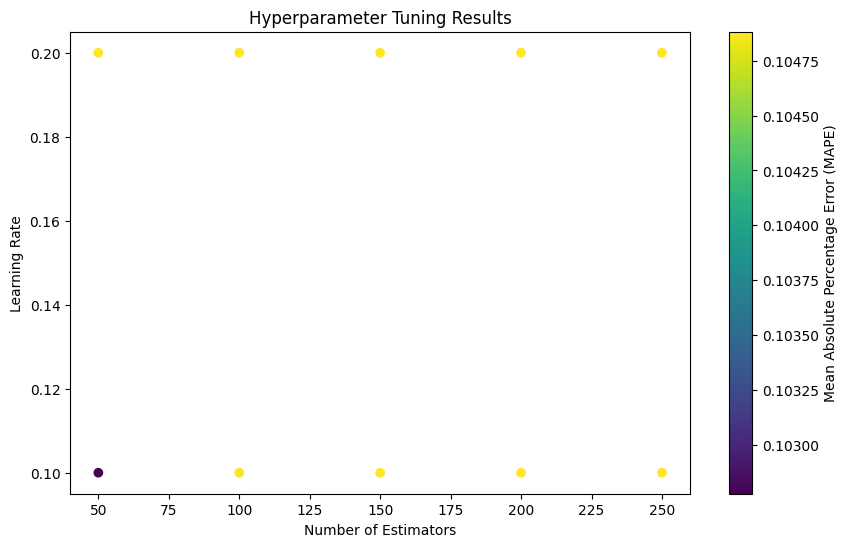

In [28]:
import matplotlib.pyplot as plt
import numpy as np

# Convert gs_results to the required lists
n_estimators_val = [param_dict["n_estimators"] for param_dict in gs_results["params"]]
learning_rate_val = [param_dict["learning_rate"] for param_dict in gs_results["params"]]
mape_val = [-score for score in gs_results["mean_test_score"]]  # Negating to get positive MAPE values

# Create a scatter plot of hyperparameter combinations vs MAPE
plt.figure(figsize=(10, 6))
sc = plt.scatter(n_estimators_val, learning_rate_val, c=mape_val, cmap='viridis')
plt.colorbar(sc, label='Mean Absolute Percentage Error (MAPE)')
plt.xlabel('Number of Estimators')
plt.ylabel('Learning Rate')
plt.title('Hyperparameter Tuning Results')
plt.show()